# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
import datetime
import pandas as pd
import nltk
import numpy as np
import random

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from typing import Tuple

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/uclm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from src.robin.supply.entities import Supply

path_config_supply = '../configs/test_case/supply_data.yml'

supply = Supply.from_yaml(path_config_supply)

# Get set of corridors
corridors = []
for service in supply.services:
    if service.line.corridor not in corridors:
        corridors.append(service.line.corridor)

# Get set of paths
paths = []
for corridor in corridors:
    for path in corridor.paths:
        if path not in paths:
            paths.append(path)

# Parse paths of Station objects to paths of station mame
paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [4]:
def get_word_syn(word: str) -> str:
    """
    Get a random synonym of a word

    Args:
        word (str): Word to get the synonym from

    Returns:
        str: Synonym of the word
    """
    word_synset = wordnet.synsets(word)
    if len(word_synset) > 0:
        station_synset = word_synset[0]
        station_lemmas = station_synset.lemmas()
        if len(station_lemmas) > 0:
            word_lemma = random.choice(station_lemmas)
            return word_lemma.name().lower()

    return word

def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [5]:
stations_csv_path = f'../data/renfe/renfe_stations.csv'

def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [6]:
n_passengers = 10000

pairs = []
for _ in range(n_passengers):
    pairs.append(get_random_pair(paths))

df = pd.DataFrame(pairs, columns=['origin', 'destination'])

user_patterns = ("business", "student", "tourist")

df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

random_timedelta = lambda: datetime.timedelta(days=random.randint(0, 365*10), hours=random.randint(0, 24), minutes=random.randint(0, 60))
df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
print(df.head())

df_time = pd.DataFrame()
df_time['year'] = df['arrival_date'].apply(lambda x: x.year)
df_time['month'] = df['arrival_date'].apply(lambda x: x.month)
df_time['day'] = df['arrival_date'].apply(lambda x: x.day)
df_time['hour'] = df['arrival_date'].apply(lambda x: x.hour)
df_time['minute'] = df['arrival_date'].apply(lambda x: x.minute)

scaler = MinMaxScaler()
df_time['year'] = scaler.fit_transform(df_time['year'].to_numpy().reshape(-1, 1))

cyclical = CyclicalFeatures(variables=['month', 'day', 'hour', 'minute'], drop_original=True)
df_time = cyclical.fit_transform(df_time)

print(df_time.head())

     origin destination user_pattern        arrival_date
0    lleida    figueres      tourist 2026-05-19 00:59:00
1    lleida    figueres      tourist 2027-11-04 14:09:00
2    madrid    figueres      student 2026-04-10 16:31:00
3  zaragoza      girona      tourist 2026-10-12 13:01:00
4  zaragoza   barcelona      student 2029-06-19 09:55:00
       year     month_sin  month_cos   day_sin   day_cos  hour_sin  hour_cos  \
0  0.555556  5.000000e-01  -0.866025 -0.651372 -0.758758  0.000000  1.000000   
1  0.666667 -5.000000e-01   0.866025  0.724793  0.688967 -0.631088 -0.775711   
2  0.555556  8.660254e-01  -0.500000  0.897805 -0.440394 -0.942261 -0.334880   
3  0.555556 -8.660254e-01   0.500000  0.651372 -0.758758 -0.398401 -0.917211   
4  0.888889  1.224647e-16  -1.000000 -0.651372 -0.758758  0.631088 -0.775711   

     minute_sin  minute_cos  
0 -2.449294e-16    1.000000  
1  8.183028e-01    0.574787  
2 -1.590635e-01   -0.987268  
3  1.062935e-01    0.994335  
4 -4.132122e-01    0.910635

In [7]:
# Get bag of words
words_set = set(df[['origin', 'destination', 'user_pattern', ]].values.flatten())

print(words_set)

{'student', 'tarragona', 'barcelona', 'guadalajara', 'madrid', 'tourist', 'calatayud', 'zaragoza', 'business', 'figueres', 'girona', 'lleida'}


In [8]:
# Import GloVe embeddings 50D
import os
import numpy as np

EMBEDDING_DIM = 50

word_index = {word: index for index, word in enumerate(words_set)}

embeddings_index = {}
f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype=np.float32)
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
embedding_dict = {}
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    print(word, embedding_vector)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embedding_dict[word] = embedding_vector

Found 400000 word vectors.
student [-1.0729    0.94103   0.084904 -1.0766    0.42866   0.099877 -0.51081
 -0.24961  -0.30883   0.19553   0.1965   -0.73152   0.096916 -0.062686
  0.12078  -0.72384  -0.382     0.6934    0.32956   0.40244   0.53485
  0.91781  -0.44553   0.71804  -0.13635  -1.6906    0.15818  -1.2367
 -1.2278   -0.058566  2.7544    0.18672  -0.263    -1.2792    0.16992
  0.40748   0.12248   0.11211   0.78318   0.036392 -0.40808  -0.058474
 -0.27932   0.33035   0.52384  -1.0487    0.27565   0.0363    0.048604
  0.28239 ]
tarragona [ 1.3885   -0.089092 -1.0508    0.058438 -0.50411  -0.80545   0.80153
  0.82715  -1.2087    0.45195   0.80519  -1.5551    0.34254  -0.75674
  0.028514 -0.10778  -0.059228  0.51951  -0.45246   0.96256  -0.94067
 -0.78372  -0.36429   1.6069   -1.3246    0.48912   0.53017   0.53761
  0.4855    0.50803  -0.27815   0.77234  -1.4666   -0.45942   0.26933
  0.33678  -0.36631   1.0428    0.7383    0.42628   0.67481  -0.16776
  0.2546   -0.8961   -0.65298  

In [9]:
df_embedding = pd.DataFrame()
df_embedding['origin'] = df['origin'].apply(lambda x: embedding_dict.get(x))
df_embedding['destination'] = df['destination'].apply(lambda x: embedding_dict.get(x))
df_embedding['user_pattern'] = df['user_pattern'].apply(lambda x: embedding_dict.get(x))
df_embedding['scaled_date'] = df_time.values.tolist()
df_embedding['scaled_date'] = df_embedding['scaled_date'].apply(lambda x: np.asarray(x + [0.0] * (EMBEDDING_DIM - len(x)), dtype=np.float32))
df_embedding = df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']]

input_data = df_embedding[['origin', 'destination', 'user_pattern', 'scaled_date']].values.tolist()
input_vectors = np.array([np.asarray(row, dtype=np.float32) for row in input_data])

print(input_vectors.shape)

(10000, 4, 50)


## Embedding Model

## Autoencoder model

In [32]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)

latent_dim = 4

inputs = Input(shape=input_shape)

encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

dense1 = Dense(4)(encoder)
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

encoder_model = Model(inputs, dense1)
decoder_model = Model(decoder_inputs, decoder_outputs)

model = Model(inputs, decoder_model(dense1))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 50)]           0         
                                                                 
 gru_4 (GRU)                 (None, 4, 64)             22272     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
 model_4 (Functional)        (None, 4, 50)             25714     
                                                                 
Total params: 57,526
Trainable params: 57,526
Non-trainable params: 0
_________________________________________________________________


In [36]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model
from keras import backend as K

beta = 5

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

# Latent layer
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

# Use z_mean as encoder output to obtain a disentangled latent representation
encoder_model = Model(inputs, z_mean)

decoder_model = Model(decoder_inputs, decoder_outputs)

# VAE model
vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 4, 50)]      0           []                               
                                                                                                  
 gru_40 (GRU)                   (None, 4, 64)        22272       ['input_29[0][0]']               
                                                                                                  
 gru_41 (GRU)                   (None, 32)           9408        ['gru_40[0][0]']                 
                                                                                                  
 dense_45 (Dense)               (None, 4)            132         ['gru_41[0][0]']                 
                                                                                           

In [34]:
import tensorflow as tf
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Conv1DTranspose
from keras.models import Model
from keras import backend as K

beta = 5
SEQUENCE_LENGTH = 4

input_shape = (SEQUENCE_LENGTH, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
encoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
encoder = GlobalMaxPooling1D()(encoder)

# Latent space
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(z)
decoder = tf.keras.layers.Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_outputs = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

encoder_model = Model(inputs, z_mean)
decoder_model = Model(z, decoder_outputs)

vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 4, 50)]      0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 4, 64)        9664        ['input_27[0][0]']               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 4, 32)        6176        ['conv1d_10[0][0]']              
                                                                                                  
 global_max_pooling1d_3 (Global  (None, 32)          0           ['conv1d_11[0][0]']              
 MaxPooling1D)                                                                             

In [33]:
history = model.fit(input_vectors, input_vectors, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
313/313 [==============================] - 8s 9ms/step - loss: 0.1687 - mean_squared_error: 0.1687
Epoch 2/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0812 - mean_squared_error: 0.0812
Epoch 3/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0566 - mean_squared_error: 0.0566
Epoch 4/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0439 - mean_squared_error: 0.0439
Epoch 5/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 6/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 8/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 9/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 10/

## Plot history

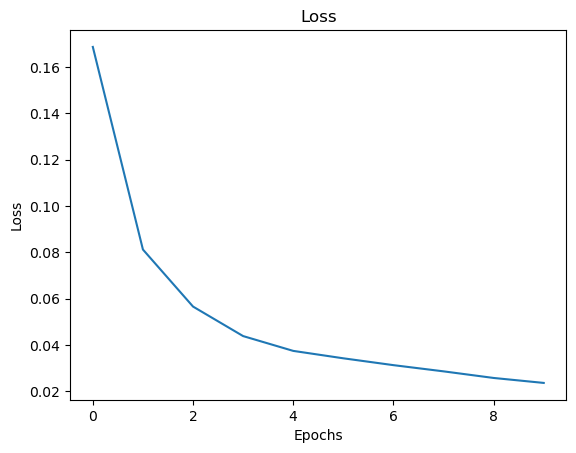

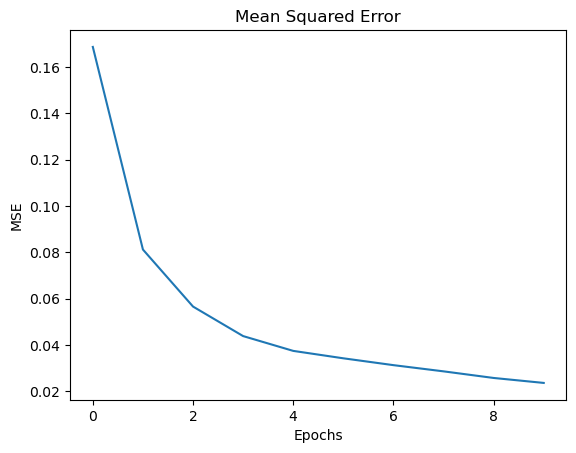

In [34]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['mean_squared_error'], label='mse')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Make predictions

In [35]:
def find_closest_embeddings(embedding, embedding_dict):
    return sorted(embedding_dict.keys(), key=lambda word: spatial.distance.euclidean(embedding_dict[word], embedding))[0]

In [36]:
random_index = np.random.randint(0, len(input_vectors))
random_vector = input_vectors[random_index]

print("Input - Random passenger data: ")
print(df.iloc[random_index])

latent_passenger = encoder_model.predict(np.array([random_vector]))[0]
print("Passenger latent representation: ", latent_passenger)
print()

prediction = model.predict(np.array([random_vector]))[0]

print("Output - Passenger reconstruction: ")
decoded_prediction = [find_closest_embeddings(word_vector, embedding_dict) for word_vector in prediction[:3]]
print(decoded_prediction)
predicted_year = scaler.inverse_transform(np.array([prediction[-1][:1]]))
print(int(predicted_year[0][0]))



Input - Random passenger data: 
origin                  guadalajara
destination               barcelona
user_pattern               business
arrival_date    2024-09-19 14:44:00
Name: 8518, dtype: object
1/1 [==============================] - 1s 504ms/step
Passenger latent representation:  [-2.098918   4.496908   2.7648082  8.713923 ]

1/1 [==============================] - 2s 2s/step
Output - Passenger reconstruction: 
['guadalajara', 'barcelona', 'business']
2025


## Estudio de la correlación entre factores latentes y la entrada del autoencoder